# Generate Synthetic Data

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

random_seed = 42
module_name = f"spiker_seg/{random_seed}"

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

sim_par= SimParams(
            h_v_init=-65.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.2,0.3],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        )

sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=module_name,
        cell= target_cell,
        sim_params= sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Blocking: []
Total number of jobs: 3
Total number of proccessors: 192
/home/mwsrgf/proj/ACT/model/spiker_seg/42/synthetic_0.1_0.2_0.3_


(5000,)


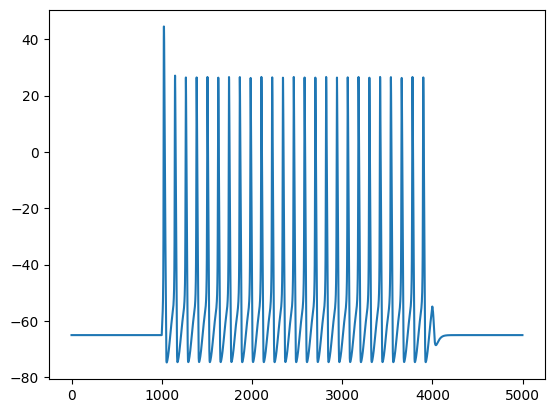

In [2]:
import numpy as np
dataset = np.load(f"./model/{module_name}/synthetic_0.1_0.2_0.3_/combined_out.npy")

V = dataset[0,:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

In [3]:
passive_sim_par = SimParams(
            h_v_init = -65,
            h_tstop = 500,
            h_dt = 0.1,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-0.1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 300,
            CI_delay = 100,
            set_g_to=[]
        )

sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=module_name,
        cell= target_cell,
        sim_params= passive_sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: []
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_seg/42/synthetic_-0.1_


(5000,)


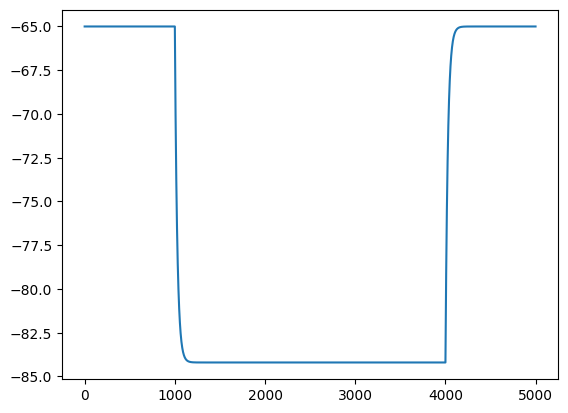

In [4]:
import numpy as np
dataset = np.loadtxt(f'./model/{module_name}/target/passive_data.csv', delimiter=',', skiprows=1)

V = dataset[:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

# Get Passive Properties

In [5]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=passive_sim_par,
    trace_filepath=f"./model/{module_name}/target/passive_data.csv",
    leak_conductance_variable="gl_hh_seg",
    leak_reversal_variable="el_hh_seg"
)

In [6]:
passive_mod.set_passive_properties()
print(train_cell.passive_properties)

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
PassiveProperties(V_rest=-65.0, R_in=191.99802919980584, tau=2.7, Cm=1.2664890000000124, g_bar_leak=0.00046907000000000453, cell_area=1.1103645074847766e-05, leak_conductance_variable='gl_hh_seg', leak_reversal_variable='el_hh_seg')


# Run Original Pipeline with Passive Prediction

In [7]:
from act.ACTModule import ACTModule
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import  Cell, SimParams, OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

mod = ACTModule(
    ModuleParameters(
        module_folder_name=module_name,
        cell= train_cell,
        target_traces_file = "target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gnabar_hh_seg", low=0.06, high=0.18, n_slices=15),
                OptimizationParam(param="gkbar_hh_seg", low=0.018, high=0.054, n_slices=15),
                OptimizationParam(param="gl_hh_seg", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1),
                
            ],
            prediction_eval_method='fi_curve',
            random_state=random_seed,
            save_file= "model/" + module_name + "/results/saved_metrics.json"
        )
    )
)

In [8]:
predicted_g_data_file = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 27
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_seg/42/train
TRAINING RANDOM FOREST REGRESSOR
-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)



100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval 1', 'Interspike Interval 2', 'Interspike Interval 3', 'Interspike Interval 4', 'Interspike Interval 5', 'Interspike Interval 6', 'Interspike Interval 7', 'Interspike Interval 8', 'Interspike Interval 9', 'Interspike Interval 10', 'Interspike Interval 11', 'Interspike Interval 12', 'Interspike Interval 13', 'Interspike Interval 14', 'Interspike Interval 15', 'Interspike Interval 16', 'Interspike Interval 17', 'Interspike Interval 18', 'Interspike Interval 19', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Mean Voltage', 'Std Voltage', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
Evaluating random forest
MAE: 0.006078 (0.002147)
Saving rf mean/stdev scores to model/spiker_seg/42/results/saved_metrics.json
Predicted Conductances for each current injection intensity: 
[[0.12072    0.033426   0.00046907]
 [0.12006    0.03357 

In [9]:
mod.pickle_rf(mod.rf_model,f"./model/{module_name}/trained_rf.pkl")

In [10]:
from act import ACTPlot
ACTPlot.plot_v_comparison(predicted_g_data_file, f"./model/{module_name}/target", f"./model/{module_name}", sim_par["CI_amps"])
ACTPlot.plot_fi_comparison(f"./model/{module_name}/results/frequency_data.npy", sim_par["CI_amps"])

# Closer Look

In [11]:
from act.Metrics import Metrics

metrics = Metrics()

mean, stdev = metrics.print_interspike_interval_comparison(
    f"./model/{module_name}/prediction_eval1/combined_out.npy",
    f"./model/{module_name}/target/combined_out.npy", 
    sim_par["CI_amps"], 
    5,
    sim_par["h_dt"],
    save_file="model/" + module_name + "/results/saved_metrics.json"
)

Interspike times (Target): [[102.4 114.8 126.8 138.7 150.7]
 [101.9 113.  123.7 134.3 145. ]
 [101.6 112.1 122.1 132.  142. ]]
Interspike times (Prediction): [[102.5 114.8 126.6 138.5 150.3]
 [101.9 112.8 123.2 133.6 144. ]
 [101.6 111.9 121.6 131.3 140.9]]
MAE for each I injection: [0.180000000000004, 0.48000000000000115, 0.49999999999999717]
Mean interspike-interval MAE: 0.38666666666666744
Standard Deviation interspike-interval MAE: 0.14636332266733196


In [12]:
from act.DataProcessor import DataProcessor
import numpy as np

dp = DataProcessor()

# Get Target Cell Frequencies
dataset = np.load(f"./model/{module_name}/target/combined_out.npy")

V_target = dataset[:,:,0]

target_frequencies = dp.get_fi_curve(V_target, sim_par["CI_amps"], inj_dur=sim_par["CI_dur"]).flatten()
print(target_frequencies)

[ 83.33333333  96.66666667 103.33333333]


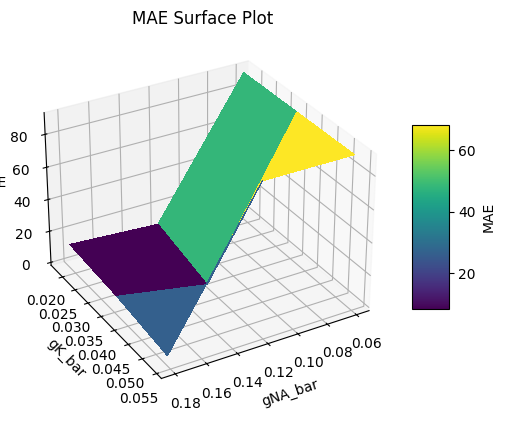

In [13]:
import os
import numpy as np
from matplotlib import pyplot as plt

from act.DataProcessor import DataProcessor
from act.Metrics import Metrics
from matplotlib import cm

from act import ACTPlot as actplt

actplt.plot_training_fi_mae_surface_spiker_cell(
f"./model/{module_name}/target/combined_out.npy",
f"./model/{module_name}/train/combined_out.npy",
sim_par["CI_amps"],
sim_par["CI_dur"],
sim_par["CI_delay"],
sim_par["h_dt"],
f"./model/{module_name}/results/FI_MAE_Surface.html",
)

Smallest MAE values (gNa, gK, MAE): 
[[1.20000000e-01 3.60000000e-02 0.00000000e+00]
 [1.80000000e-01 5.40000000e-02 4.44444444e+00]
 [1.20000000e-01 1.80000000e-02 1.00000000e+01]
 [1.80000000e-01 3.60000000e-02 1.00000000e+01]
 [1.80000000e-01 1.80000000e-02 1.33333333e+01]
 [6.00000000e-02 1.80000000e-02 9.11111111e+01]]


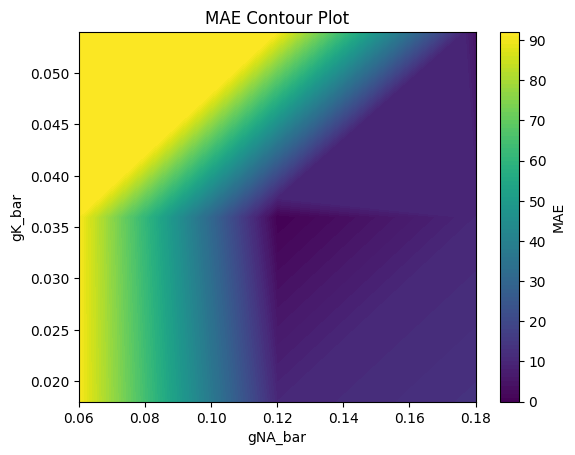

In [14]:
from act import ACTPlot as actplt

actplt.plot_training_fi_mae_contour_plot(
f"./model/{module_name}/target/combined_out.npy",
f"./model/{module_name}/train/combined_out.npy",
sim_par["CI_amps"],
sim_par["CI_dur"],
sim_par["CI_delay"],
sim_par["h_dt"],
100,
f"./model/{module_name}/results/contour_map.png",
)

found indices: 9
found indices: 9
found indices: 9


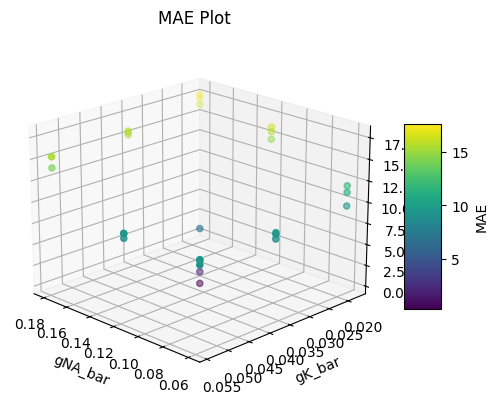

In [15]:
from act import ACTPlot as actplt

actplt.plot_training_v_mae_scatter_spiker_cell(
    f"./model/{module_name}/target/combined_out.npy",
    f"./model/{module_name}/train/combined_out.npy",
    sim_par['CI_delay'],
    sim_par['h_dt']
)


In [16]:
import numpy as np
from scipy import signal

from scipy.signal import find_peaks

def extract_spike_features(traces, spike_threshold = 0, num_spikes=20, dt=1):
    num_of_spikes_list = []
    spike_times_list = []
    interspike_intervals_list = []
    min_spike_height_list = []
    max_spike_height_list = []
    
    pad_value=1e6
    
    for trace in traces:

        peak_idxs, _ = find_peaks(trace, threshold=spike_threshold, height=spike_threshold)
        
        num_of_spikes = len(peak_idxs)
        num_of_spikes_list.append(num_of_spikes)
        
        spike_times = peak_idxs[:num_spikes] * dt
        spike_times_padded = np.pad(spike_times, (0, num_spikes - len(spike_times)), 'constant', constant_values=pad_value)
        spike_times_list.append(spike_times_padded)
        
        interspike_intervals = np.diff(spike_times)
        interspike_intervals_padded = np.pad(interspike_intervals, (0,num_spikes - 1 - len(interspike_intervals)), 'constant', constant_values=pad_value)
        interspike_intervals_list.append(interspike_intervals_padded)
        
        spike_heights = trace[peak_idxs]
        min_spike_height = np.min(spike_heights) if len(spike_heights) > 0 else np.nan
        min_spike_height_list.append(min_spike_height)
        
        max_spike_height = np.max(spike_heights) if len(spike_heights) > 0 else np.nan
        max_spike_height_list.append(max_spike_height)
        
    return np.array(num_of_spikes_list), np.array(spike_times_list), np.array(interspike_intervals_list), np.array(min_spike_height_list), np.array(max_spike_height_list)
    


In [17]:
import numpy as np
from act.DataProcessor import DataProcessor

dp = DataProcessor()

dataset = np.load("/home/mwsrgf/proj/ACT/model/spiker_seg/22/train/combined_out.npy")

V = dataset[:,:,0]
sample = 26

num_of_spikes, spike_times, interspike_intervals, min_spike_height, max_spike_height = dp.extract_spike_features(V, spike_threshold=0, num_spikes=20, dt=0.1)

print(num_of_spikes)
print(spike_times)
print(interspike_intervals)
print(min_spike_height)
print(max_spike_height)

from matplotlib import pyplot as plt

plt.plot(V[sample])

AttributeError: 'DataProcessor' object has no attribute 'extract_spike_features'